# 9 - Flow Duration Curves

# Flow Duration Curves

Get this document and a version with empty code chunks at the template
repository on github:
<https://github.com/VT-Hydroinformatics/9-Flow-Duration-Curves>

Alright team. So far we have learned to wrangle data, make plots, and
look at data distributions. Now it is time to put all that knowledge to
use.

We are on our way to doing analyses of extreme discharge events: low
flow statistics and floods. But in order to do that, we need to
understand a common way to look at data distributions in hydrology: the
flow duration curve. As you’ll see below, this is basically just a
different way of looking at a pdf, and it can take some getting used to.
But it is also a very useful tool!

As always let’s load the packages we will use: tidyverse, dataRetrieval,
lubridate, and patchwork. Patchwork will help us make a multi-panel
graph in the last part of the exercise.

We will also use theme_set() in this chunk so we don’t have to change
the ggplot theme every time we make a plot.

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

## Get data

To start, let’s grab the USGS discharge data for the gage in Linville NC
from 1960 to 2020.

We will download the data using USGS dataRetrieval and look at a line
plot.

read_waterdata_daily.

GET: https://waterservices.usgs.gov/nwis/dv/?site=02138500&format=waterml%2C1.1&ParameterCd=00060&StatCd=00003&startDT=1960-01-01&endDT=2020-01-01

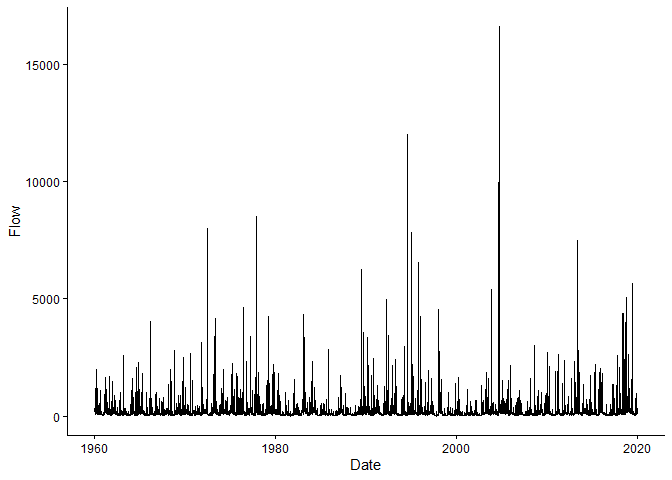

In [ ]:
siteno <- "02138500" #Linville NC
startDate <- "1960-01-01"
endDate <- "2020-01-01"
parameter <- "00060"

Qdat <- readNWISdv(siteno, parameter, startDate, endDate) |> 
  renameNWISColumns()

## Review: describe the distribution

Make a plot to view the distribution of the discharge data.

-   What is the median flow value?
-   What does this tell us about flow at that river?
-   How often is the river at or below that value?
-   Could you pick that number off the plot?
-   What about the flow the river is at or above only 5% of the time?

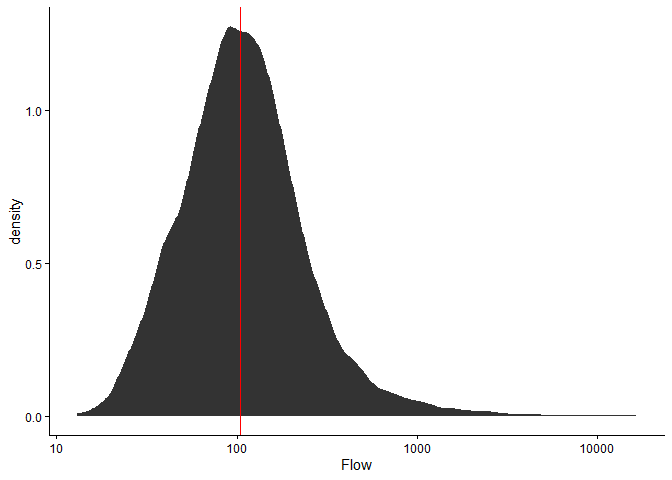

In [ ]:
Qdat |> ggplot(aes(Flow))+
  stat_density()+
  scale_x_log10()+
  geom_vline(xintercept = median(Qdat$Flow), color = "red")

## ECDFs

Let’s look at an Empirical Cumulative Density Function (ECDF) of the
data.

Look at this carefully, what does it show? How is it different from the
pdf of the data?

Plot the median again. Without the line on the plot, how would you tell
where the median is?

Given your answer to the question above, can you determine the flow the
river is at or above only 25% of the time? Think carefully about what
the y axis of the ECDF means.

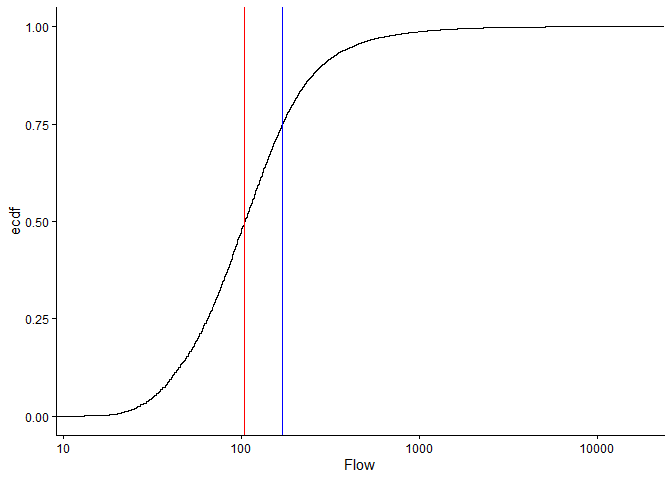

In [ ]:
Qdat |> ggplot(aes(Flow))+
  stat_ecdf()+
  scale_x_log10()+
  geom_vline(xintercept = median(Qdat$Flow), color = "red")+
  geom_vline(xintercept = quantile(Qdat$Flow)[4], color = "blue")

## Calculate flow exceedence probabilities

In hydrology, it is common to look at a similar representation of flow
distributions, but with flow on the Y axis and “% time flow is equaled
or exceeded” on the X axis. There are a number of ways we could make
this plot: for example we could transform the axes of the plot above or
we could use the function that results from the ECDF function in R to
calculate exceedence probabilities at flow throughout our range of
flows. But for our purposes, we are just going to calculate it manually.

We are going to calculate our own exceedence probabilities because
knowing how to do this will hopefully help us understand what a flow
duration curve is AND we will need to do similar things in our high and
low flow analyses.

The formula for exceedence probability (P) is below. What do we need to
calculate this?

Exceedence probability (P), Probability a flow is equaled or exceeded

$P = 100 * [M / (n + 1)]$

M = Ranked position of the flow n = total number of observations in data
record

Here’s a description of what we will do: \> Pass our Qdat data to mutate
and create a new column that is equal to the ranks of the discharge
column. \> Then pass that result to mutate again and create another
column equal exceedence probability (P) \* 100, which will give us %.

In [ ]:
#Flow is negative in rank() to make 
#high flows ranked low (#1)
Qdat <- Qdat |>
  mutate(rank = rank(-Flow)) |>
  mutate(P = 100 * (rank / (length(Flow) + 1)))

## Plot a Flow Duration Curve using the probabilities

Now construct the following plot: A line with P on the x axis and flow
on the y axis. Name the x axis “% Time flow equaled or exceeded” and log
the y axis.

That’s a flow duration curve!

Questions about the flow duration curve: \* How often is a flow of 100
cfs exceeded at this gage? \* Is flow more variable for flows exceeded
0-25% or of the time or 75-100% \* of the time? \* How can you tell? \*
These data are daily observations. Given that, what is a more accurate
name for the x axis? \* What would the X axis be called if we were using
maximum yearly data?

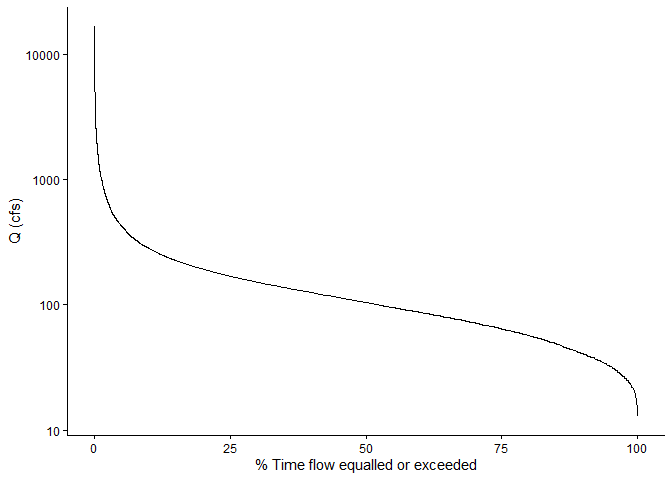

In [ ]:
Qdat |> ggplot(aes(x = P, y = Flow))+
  geom_line()+
  scale_y_log10()+
  xlab("% Time flow equalled or exceeded")+
  ylab("Q (cfs)")

## Make an almost FDC with stat_ecdf

Below is an example of making a very similar plot with the stat_ecdf()
geometry in ggplot. Notice how similar the result is to the one we
calculated manually.

To make the plot similar, we will reverse the y axis of the ecdf plot
with scale_y_reverse and flip the axes (change the x to y and the y to
x) with coord_flip()

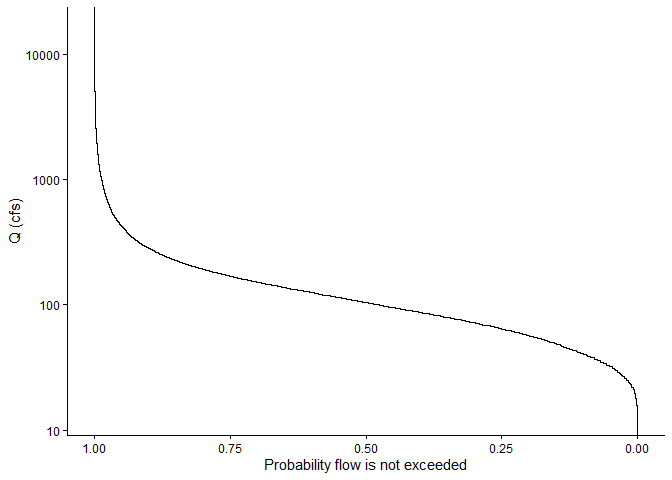

In [ ]:
Qdat |> ggplot(aes(Flow))+
  stat_ecdf()+
  scale_x_log10()+
  scale_y_reverse()+
  coord_flip()+
  xlab("Q (cfs)")+
  ylab("Probability flow is not exceeded")

## Example use of an FDC

Let’s explore one potential use of flow duration curves: examining the
differences between two sets of flow data.

From the line plot of the discharge, it looked like the flow regime may
have shifted a bit in the data between the early years and newer data.
Let’s use flow duration curves to examine potential differences. We can
come up with groups and then use group_by to run the analysis by groups
instead of the whole dataset.

We are introducing a new function here called case_when(). This allows
you to assign values to a new column based on values in another column.
In our case, we are going to name different time periods in our data.

We will then group the data by these periods and calculate exceedence
probabilities for each. The procedure works the same, except we add a
group_by statement to group by our time period column before we create
the rank and P columns. Then, when we plot, we can just tell ggplot to
create different colored lines based on the time period names and it
will plot a separate flow duration curve for each. Tidyverse FOR THE
WIN!

Describe the differences in flow regime you see between the three
periods of 1960-1980, 1980-2000, and 2000-2020.

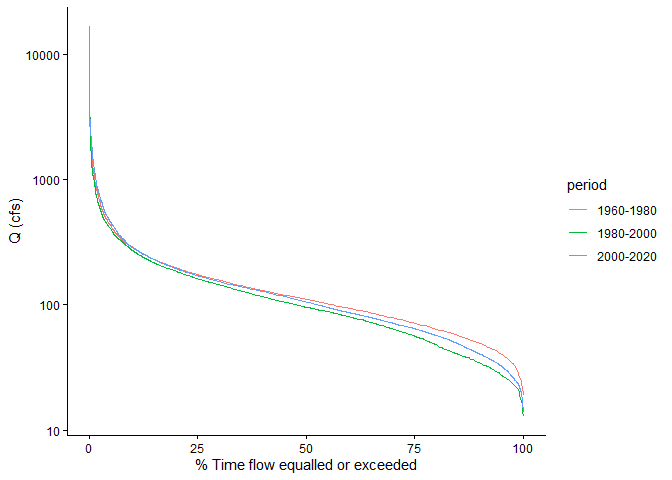

In [ ]:
Qdat <- Qdat |>
  mutate(year = year(Date)) |>
  mutate(period = case_when( year <= 1980 ~ "1960-1980",
                             year > 1980 & year <= 2000 ~ "1980-2000",
                             year > 2000 ~ "2000-2020"))

Qdat <- Qdat |>
  group_by(period) |>
  mutate(rank = rank(-Flow)) |> 
  mutate(P = 100 * (rank / (length(Flow) + 1)))

Qdat |> ggplot(aes(x = P, y = Flow, color = period))+
  geom_line()+
  scale_y_log10()+
  xlab("% Time flow equalled or exceeded")+
  ylab("Q (cfs)")

## Compare to a boxplot of the same data

We are really just looking at the data distribution here. Remember
another good way to compare distributions is a boxplot. Let’s create a
boxplot showing flows from these time periods. (we will also mess with
the dimensions of the plot so the boxes aren’t so wide using fig.width
and fig.height in the \`\`\` header above the code chunk)

What are the advantages/disadvantages of the flow duration curves
vs. boxplots?

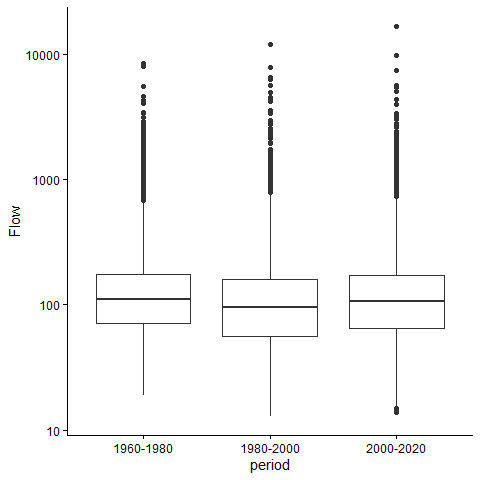

In [ ]:
Qdat |> ggplot(aes(x = period, y = Flow)) +
  geom_boxplot()+
  scale_y_log10()

## Challenge: Examining flow regime change at the Grand Canyon

The USGS Gage “Colorado River at Yuma, AZ” is below the Hoover dam. The
Hoover Dam closed in 1936, changing the flow of the Colorado River
below. Load average daily discharge data from 10-01-1905 to 10-01-1965
from the Yuma gage. Use a line plot of discharge and flow duration
curves to examine the differences in discharge for the periods: 1905 -
1936, 1937 - 1965.

How does the FDC show the differences you observed in the line plot?

read_waterdata_daily.

GET: https://waterservices.usgs.gov/nwis/dv/?site=09521000&format=waterml%2C1.1&ParameterCd=00060&StatCd=00003&startDT=1905-10-01&endDT=1965-10-01

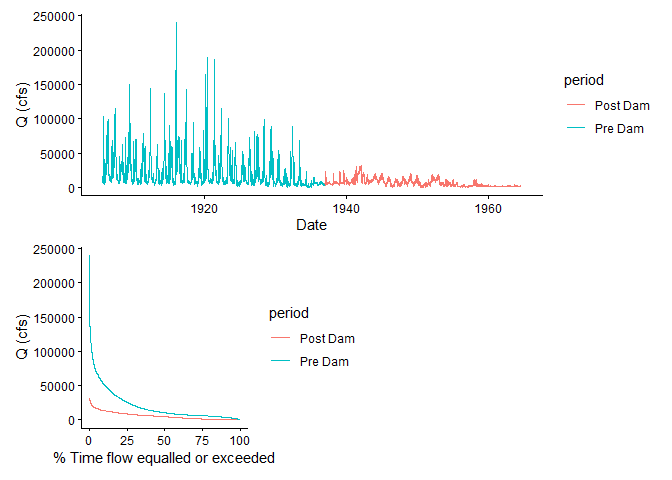

In [ ]:
siteid <- "09521000"
startDate <- "1905-10-01"
endDate <- "1965-10-01"
parameter <- "00060"

WS <- readNWISdv(siteid, parameter, startDate, endDate) |> 
  renameNWISColumns() |>
  mutate(year = year(Date)) |>
  mutate(period = case_when( year <= 1936 ~ "Pre Dam",
                             year > 1936  ~ "Post Dam")) |>
  group_by(period) |>
  mutate(rank = rank(-Flow)) |> 
  mutate(P = 100 * (rank / (length(Flow) + 1)))

That’s it! Next we will apply some of these principles to look at
low-flow statistics.